## Messing around with reinforcement learning and multi-agent trading

In [1]:
import numpy as np
import torch
from itertools import product
from collections import defaultdict

### Q class

In [2]:
class Q_table:

    def __init__(self,
                 Np = 31,
                 Nv = 10, 
                 Nx = 15,
                 initial_values = None):

        self.Np = range(Np)
        self.Nv = range(Nv)

        self.states = list(product(self.Np, self.Nv))

        self.Q = {s:np.zeros(Nx) for s in self.states}

        # if initial_values is not None:
        #     self.Q = initial_values
        
    def get_Q_value(self, state, action):
        return self.Q[state][action]

    def get_best_action(self, state):
        return np.argmax(self.Q[state])

    def get_best_value(self, state):
        return np.max(self.Q[state])

    def update(self, state, action, value):
        self.Q[state][action] = value

### Fixed-point iteration methods for solving discretization

In [3]:
def solve_chiN(I, xi, sigma_u, sigma_v, theta, tol=1e-12, max_iter=10000):
    """
    Solve for the noncollusive slope chi^N in the Kyle-type model.

    We use the 3-equation system from Section 3.2 in the paper:
      (1) chi^N = 1 / [(I+1)*lambda^N]
      (2) lambda^N = [theta * gamma^N + xi] / (theta + xi^2)
      (3) gamma^N = (I*chi^N) / [(I*chi^N)^2 + (sigma_u/sigma_v)^2]

    We do simple fixed-point iteration over chi^N.

    Returns:
      float: chi^N
      float: lambda^N
    """
    chi = 0.1  # Arbitrary initial guess
    for _ in range(max_iter):
        # Given chi, compute gamma^N:
        gamma = (I * chi) / ((I * chi)**2 + (sigma_u / sigma_v)**2)

        # Then lambda^N:
        lam = (theta * gamma + xi) / (theta + xi**2)

        # Then the updated chi^N:
        new_chi = 1.0 / ((I + 1) * lam)

        if abs(new_chi - chi) < tol:
            return new_chi, lam
        chi = new_chi

    raise RuntimeError("solve_chiN did not converge within max_iter")


def solve_chiM(I, xi, sigma_u, sigma_v, theta, tol=1e-12, max_iter=10000):
    """
    Solve for the *perfect-collusion* slope chi^M in the Kyle-type model.

    From Section 3.3 in the paper:
      (1) chi^M = 1 / [2*I * lambda^M]
      (2) lambda^M = [theta * gamma^M + xi] / (theta + xi^2)
      (3) gamma^M = (I*chi^M) / [(I*chi^M)^2 + (sigma_u/sigma_v)^2]

    Similar fixed-point iteration as above.
    """
    chi = 0.1  # Arbitrary initial guess
    for _ in range(max_iter):
        gamma = (I * chi) / ((I * chi)**2 + (sigma_u / sigma_v)**2)
        lam = (theta * gamma + xi) / (theta + xi**2)
        new_chi = 1.0 / (2.0 * I * lam)

        if abs(new_chi - chi) < tol:
            return new_chi, lam
        chi = new_chi

    raise RuntimeError("solve_chiM did not converge within max_iter")

### Informed (potentially) Collusive Agents

In [4]:
I = 3                       # Global variable for number of informed traders

class InformedAgent:

    def __init__(
            self, 
            Np = 31,        # number of grid points for the price
            Nv = 10,        # number of grid points for the value
            Nx = 15,        # number of grid points for the order flow
            
            rho = 0.95,     # discount factor
            alpha = 0.01,   # learning rate (forgetting factor)
            beta = 1e-5,    # epsilon decay rate
            
            sigma_v = 1,    # volatility of the security value
            v_bar = 1,      # expected value of the security
            sigma_u = 0.1,  # volatility of the order flow
            xi = 500,       # risk aversion parameter
            theta = 0.1,    # market maker's pricing error risk aversion parameter
            iota = 0.1      # span of the grid around the optimal price
            ):
        
        # parameters
        self.n_actions = Nx
        self.Np = Np
        self.Nv = Nv
        self.n_states = Np * Nv

        self.rho = rho
        self.alpha = alpha
        self.beta = beta

        self.sigma_v = sigma_v
        self.v_bar = v_bar
        self.sigma_u = sigma_u
        self.xi = xi
        self.theta = theta
        self.iota = iota

        # Q-table for RL
        self.Q = Q_table(Np = Np, Nv = Nv, Nx = Nx)

        # state count dictionary for epsilon decay
        self.state_count = defaultdict(int)

        # convergence dictionary
        self.last_optimal = {}
        self.convergence_counter = 0

        # discretization of states
        self.get_discrete_states()

        # initialize Q-table
        self.initialize_Q()

    
    def get_epsilon(self, state):
        v = self.state_count[state]
        self.state_count[state] += 1
        return np.exp(-self.beta * v)
    
    def get_action(self, state):
        epsilon = self.get_epsilon(state)
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_actions)
        else:
            optimal_action = self.Q.get_best_action(state)
            self.check_convergence(state, optimal_action)
            return optimal_action
        
    def update(self, state, action, reward, next_state):
        learning = self.alpha * (reward + self.rho * self.Q.get_best_value(next_state))
        memory = (1 - self.alpha) * self.Q.get_Q_value(state, action)
        value = learning + memory
        self.Q.update(state, action, value)
    
    def get_grid_point_values_v(self):
        """
        Returns a zero indexed dictionary of the grid points for the state space of v
        """
        standard_normal = torch.distributions.Normal(0, 1)
        grid_point = [(2 * k - 1) / (2 * self.Nv) for k in range(1, self.Nv + 1)]
        values = standard_normal.icdf(torch.tensor(grid_point))
        return {idx: float(self.v_bar + self.sigma_v * value) for idx, value in enumerate(values)}
    
    def get_grid_point_values_x(self):
        self.chiN, self.lambdaN = solve_chiN(I = I, xi = self.xi, sigma_u = self.sigma_u, sigma_v = self.sigma_v, theta = self.theta)
        self.chiM, self.lambdaM = solve_chiM(I = I, xi = self.xi, sigma_u = self.sigma_u, sigma_v = self.sigma_v, theta = self.theta)
        self.x_n, self.x_m = self.chiN, self.chiM # assuming v - v_bar = 1
        span_x = abs(self.x_n - self.x_m)
        low, high = -max(self.x_n, self.x_m) - self.iota * span_x, max(self.x_n, self.x_m) + self.iota * span_x
        values = np.linspace(low, high, self.n_actions)
        return {idx: float(val) for idx, val in enumerate(values)}
    
    def get_grid_point_values_p(self):
        try:
            lambda_for_p = max(self.lambdaN, self.lambdaM)
        except:
            raise ValueError("Call get_grid_point_values_x() first")
        ph = self.v_bar + lambda_for_p * (I * max(self.x_n, self.x_m) + self.sigma_u * 1.96)
        pl = self.v_bar - lambda_for_p * (I * max(self.x_n, self.x_m) + self.sigma_u * 1.96)
        span_p = ph - pl
        values = np.linspace(pl - self.iota * span_p, ph + self.iota * span_p, self.Np)
        return {idx: float(val) for idx, val in enumerate(values)}
    
    def get_discrete_states(self):
        self.v_discrete = self.get_grid_point_values_v()
        self.x_discrete = self.get_grid_point_values_x()
        self.p_discrete = self.get_grid_point_values_p()

    def continuous_to_discrete(self, p, v):
        p_idx = min(self.p_discrete, key=lambda x: abs(self.p_discrete[x] - p))
        v_idx = min(self.v_discrete, key=lambda x: abs(self.v_discrete[x] - v))
        return p_idx, v_idx

    def initialize_Q(self):
        for p in range(self.Np):
            for v in range(self.Nv):
                state = (p, v)
                for x in range(self.n_actions):
                    value = 0
                    for x_i in range(self.n_actions):
                        value += self.v_discrete[v] - (self.v_bar + self.lambdaN * (self.x_n + (I - 1) * self.x_discrete[x_i]))
                    value *= self.x_discrete[x] / ((1 - self.rho) * self.n_actions)
                    self.Q.update(state, x, value)

    def check_convergence(self, state, action):
        # print(self.last_optimal)
        if action != self.last_optimal.get(state, None):
            self.last_optimal[state] = action
            self.convergence_counter = 0

        else:
            self.convergence_counter += 1

        
        


{0: -0.6448533535003662, 1: -0.03643333911895752, 2: 0.32551026344299316, 3: 0.6146795153617859, 4: 0.8743386268615723, 5: 1.1256613731384277, 6: 1.3853204250335693, 7: 1.6744897365570068, 8: 2.036433696746826, 9: 2.644853353500366}
{0: -129.16665166667082, 1: -110.71427285714641, 2: -92.26189404762201, 3: -73.80951523809762, 4: -55.35713642857321, 5: -36.90475761904881, 6: -18.45237880952442, 7: 0.0, 8: 18.45237880952439, 9: 36.90475761904878, 10: 55.3571364285732, 11: 73.80951523809759, 12: 92.26189404762198, 13: 110.7142728571464, 14: 129.16665166667082}
{0: 0.09952935981182495, 1: 0.15956073582436997, 2: 0.21959211183691496, 3: 0.27962348784946, 4: 0.339654863862005, 5: 0.39968623987455, 6: 0.45971761588709503, 7: 0.5197489918996401, 8: 0.579780367912185, 9: 0.6398117439247301, 10: 0.6998431199372751, 11: 0.7598744959498202, 12: 0.8199058719623651, 13: 0.8799372479749101, 14: 0.9399686239874552, 15: 1.0, 16: 1.060031376012545, 17: 1.12006275202509, 18: 1.1800941280376351, 19: 1.240

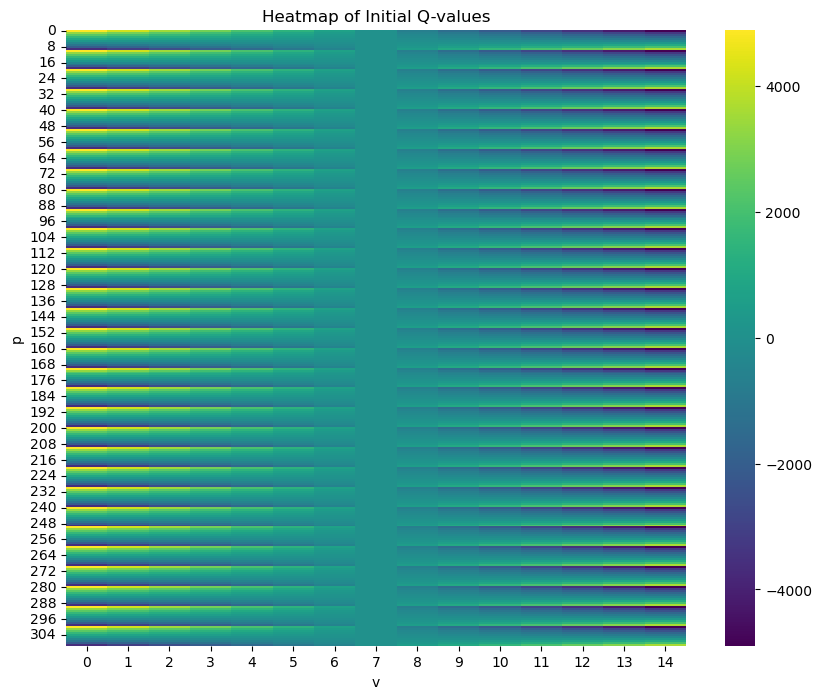

In [5]:
import seaborn as sns

a = InformedAgent(Nv = 10)
print(a.v_discrete)
print(a.x_discrete)
print(a.p_discrete)
q = a.Q.Q
import matplotlib.pyplot as plt

# Extract Q-values for a specific action (e.g., action 0)
q_values = np.array([q[state] for state in a.Q.states])

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(q_values, cmap="viridis")
plt.title("Heatmap of Initial Q-values")
plt.xlabel("v")
plt.ylabel("p")
plt.show()

### Preferred Habitat Investor

In [6]:
class PreferredHabitatAgent:

    def __init__(self, xi = 500, v_bar = 1):
        self.xi = xi
        self.v_bar = v_bar

    def get_action(self, pt):
        z = -self.xi * (pt - self.v_bar)
        return z
    
    

### Adaptive Market Makers

In [7]:
class CircularBuffer:
    """
    Circular buffer for storing historical data.
    """
    def __init__(self, size):
        self.size = size
        self.buffer = np.zeros(size)
        self.index = 0

    def add(self, value):
        self.buffer[self.index] = value
        self.index = (self.index + 1) % self.size

    def get(self):
        return np.concatenate((self.buffer[self.index:], self.buffer[:self.index]))

class AdaptiveMarketMaker:

    def __init__(self, theta = 0.1, Tm = 10000):
        self.theta = theta
        self.Tm = Tm

        self.vars_ = ['v','p','z','y']
        self.historical_data = {var: CircularBuffer(size = self.Tm) for var in self.vars_}

    def OLS(self, y, X):
        """
        Perform Ordinary Least Squares (OLS) regression.
        Parameters:
        y (CircularBuffer): The dependent variable.
        X (CircularBuffer): The independent variable(s).
        Returns:
        coef_ (ndarray): The estimated coefficients for the linear regression model.
        """
        y = y.get()
        X = X.get()
        
        X = np.vstack([X, np.ones(len(X))]).T
        coef_, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
        return coef_
    
    def determine_price(self, yt):
        """
        Determines the price based on historical data and a given input.
        This method uses Ordinary Least Squares (OLS) regression to calculate
        yt (float): The input value for which the price needs to be determined.
        Returns:
        float: The determined price based on the input `yt`.
        """

        xi_1, _ = self.OLS(self.historical_data['z'], self.historical_data['p'])
        gamma_1, gamma_0 = self.OLS(self.historical_data['v'], self.historical_data['y'])
        lambda_ = (xi_1 + self.theta * gamma_1) / (xi_1**2 + self.theta)
        # print(lambda_)
        price = gamma_0 + lambda_ * yt
        return price
    
    def update(self, vt, pt, zt, yt):
        """
        Updates the historical data with the given values.
        Parameters:
        vt (float): The value of `v` at time `t`.
        pt (float): The value of `p` at time `t`.
        zt (float): The value of `z` at time `t`.
        yt (float): The value of `y` at time `t`.
        """
        for var, value in zip(self.vars_, [vt, pt, zt, yt]):
            self.historical_data[var].add(value)

### Noise Trader

In [8]:
class NoiseAgent:
    def __init__(self, sigma = 0.1):
        self.sigma = sigma

    def get_action(self):
        return np.random.normal(scale = self.sigma)

In [ ]:
from tqdm import tqdm

def get_next_v(v_bar = 1, sigma_v = 1):
    return v_bar + np.random.normal(scale = sigma_v)

def simulate(
        T = 1000000, config = None,     # simulation time and config file
        continue_simulation = False,    # continue simulation if True
        save_path = None                # path to save the simulation
        ):
    assert config is not None, "Config file required"
    I = config.I
    Np = config.Np
    Nv = config.Nv
    Nx = config.Nx
    sigma_u = config.sigma_u
    if type(continue_simulation) == str:
        log = np.load(continue_simulation, allow_pickle=True).item()
        
        v_hist = np.zeros(T)
        p_hist = np.zeros(T)
        z_hist = np.zeros(T)
        x_hist = np.zeros((I, T))
        y_hist = np.zeros((I, T))
        profit_hist = np.zeros((I, T))
        t0 = 0

        informed_agents = log["agents"]["informed"]
        noise_agent = log["agents"]["noise"]
        preferred_habitat_agent = log["agents"]["preferred_habitat"]
        market_maker = log["agents"]["market_maker"]

        _state = log["last_state"]

        convergence_counter = log['convergence_counter']
    # elif type(continue_simulation) == dict:
    #     log = continue_simulation
    #     v_hist = log["v"]
    #     p_hist = log["p"]
    #     z_hist = log["z"]
    #     x_hist = log["x"]
    #     y_hist = log["y"]
    #     profit_hist = log["profit"]
    #     t0 = len(v_hist)
    #     informed_agents = log["agents"]["informed"]
    #     noise_agent = log["agents"]["noise"]
    #     preferred_habitat_agent = log["agents"]["preferred_habitat"]
    #     market_maker = log["agents"]["market_maker"]
    #     _state = log["last_state"]

    #     profit_hist = np.concatenate((profit_hist, np.zeros((I, T))), axis=1)
    #     v_hist = np.concatenate((v_hist, np.zeros(T)))
    #     p_hist = np.concatenate((p_hist, np.zeros(T)))
    #     z_hist = np.concatenate((z_hist, np.zeros(T)))
    #     x_hist = np.concatenate((x_hist, np.zeros((I, T))), axis=1)
    #     y_hist = np.concatenate((y_hist, np.zeros((I, T))), axis=1)

    #     convergence_counter = log['convergence_counter']
        
    elif continue_simulation == False:

        market_maker = AdaptiveMarketMaker()
        noise_agent = NoiseAgent(sigma = sigma_u)
        preferred_habitat_agent = PreferredHabitatAgent()
        informed_agents = [InformedAgent(Np = Np, Nv = Nv, Nx = Nx) for _ in range(I)]
        _state = (np.random.choice(Np), np.random.choice(Nv))

        # log histories
        v_hist = np.zeros(T)
        p_hist = np.zeros(T)
        z_hist = np.zeros(T)
        x_hist = np.zeros((I, T))
        y_hist = np.zeros((I, T))
        profit_hist = np.zeros((I, T))
        t0 = 0
        convergence_counter = 0
    else:
        raise ValueError("Invalid value for continue_simulation")
    for agent in informed_agents:
        agent.convergence_counter = convergence_counter
    if save_path is None:
        save_path = '/Users/moyuanchen/Documents/thesis/data.npy'

    for t in tqdm(range(T), desc="Simulation Progress"):
        yt = []
        _p, _v = informed_agents[0].p_discrete[_state[0]], informed_agents[0].v_discrete[_state[1]]
        v_hist[t+t0] = _v
        p_hist[t+t0] = _p
        _x = []
        for idx, agent in enumerate(informed_agents):
            x = agent.get_action(_state)
            xd = agent.x_discrete[x]
            yt.append(xd)
            _x.append(x)

            x_hist[idx, t + t0] = xd
            y_hist[idx, t + t0] = yt[-1]

        yt_sum = np.sum(yt) + noise_agent.get_action()
        # print(yt_sum)
        zt = preferred_habitat_agent.get_action(_p)

        z_hist[t+t0] = zt

        market_maker.update(_v, _p, zt, yt_sum)
        pt = market_maker.determine_price(yt_sum)
        vt = get_next_v()
        next_state = informed_agents[0].continuous_to_discrete(pt, vt)
        for idx, agent in enumerate(informed_agents):
            reward = (_v - pt) * yt[idx]
            agent.update(_state, _x[idx], reward, next_state)
            profit_hist[idx, t + t0] = reward

        _state = next_state
    convergence = min([agent.convergence_counter for agent in informed_agents])
    log = {
        "v": v_hist,
        "p": p_hist,
        "z": z_hist,
        "x": x_hist,
        "y": y_hist,
        "profit": profit_hist,
        "last_state": _state,
        "convergence_counter": convergence
    }
    agents = {
        "informed": informed_agents,
        "noise": noise_agent,
        "preferred_habitat": preferred_habitat_agent,
        "market_maker": market_maker
    }
    log["agents"] = agents
    np.save(save_path, log)
    # print(max_c)
    return log, agents

In [10]:
_save_path = '/Users/moyuanchen/Documents/thesis/data_part_0.npy'
log, agents = simulate(Np = 61, Nv = 20, Nx = 30, T = 500000, save_path=_save_path)
# log, agents = simulate(Np = 61, Nv = 20, Nx = 30, T = 20000)
convergence_threshold = 1000000
convergence = 0
partitions = 1
while convergence < convergence_threshold:
    save_path = f'/Users/moyuanchen/Documents/thesis/data_part_{partitions}.npy'
    log, agents = simulate(Np=61, Nv=20, Nx=30, T=500000, continue_simulation=_save_path, save_path=save_path)
    _save_path = save_path
    
    convergence = log['convergence_counter']
    print(f"Partition {partitions} completed, convergence counter: {convergence}")
    partitions += 1
    

Simulation Progress: 100%|██████████| 500000/500000 [02:00<00:00, 4133.21it/s]


Partition 1 completed, convergence counter: 2


Simulation Progress: 100%|██████████| 500000/500000 [02:07<00:00, 3910.42it/s]


Partition 2 completed, convergence counter: 3


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3965.44it/s]


Partition 3 completed, convergence counter: 0


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3975.38it/s]


Partition 4 completed, convergence counter: 0


Simulation Progress: 100%|██████████| 500000/500000 [02:03<00:00, 4047.72it/s]


Partition 5 completed, convergence counter: 12


Simulation Progress: 100%|██████████| 500000/500000 [02:01<00:00, 4127.88it/s]


Partition 6 completed, convergence counter: 4


Simulation Progress: 100%|██████████| 500000/500000 [02:00<00:00, 4134.75it/s]


Partition 7 completed, convergence counter: 13


Simulation Progress: 100%|██████████| 500000/500000 [02:15<00:00, 3687.17it/s]


Partition 8 completed, convergence counter: 2


Simulation Progress: 100%|██████████| 500000/500000 [02:12<00:00, 3787.69it/s]


Partition 9 completed, convergence counter: 9


Simulation Progress: 100%|██████████| 500000/500000 [02:10<00:00, 3830.81it/s]


Partition 10 completed, convergence counter: 11


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3969.28it/s]


Partition 11 completed, convergence counter: 28


Simulation Progress: 100%|██████████| 500000/500000 [02:03<00:00, 4046.19it/s]


Partition 12 completed, convergence counter: 8


Simulation Progress: 100%|██████████| 500000/500000 [02:07<00:00, 3912.95it/s]


Partition 13 completed, convergence counter: 13


Simulation Progress: 100%|██████████| 500000/500000 [02:04<00:00, 4006.10it/s]


Partition 14 completed, convergence counter: 6


Simulation Progress: 100%|██████████| 500000/500000 [02:07<00:00, 3909.53it/s]


Partition 15 completed, convergence counter: 7


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3871.92it/s]


Partition 16 completed, convergence counter: 19


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3951.40it/s]


Partition 17 completed, convergence counter: 1


Simulation Progress: 100%|██████████| 500000/500000 [02:16<00:00, 3671.26it/s]


Partition 18 completed, convergence counter: 15


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3849.79it/s]


Partition 19 completed, convergence counter: 5


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3885.50it/s]


Partition 20 completed, convergence counter: 25


Simulation Progress: 100%|██████████| 500000/500000 [02:14<00:00, 3722.38it/s]


Partition 21 completed, convergence counter: 1


Simulation Progress: 100%|██████████| 500000/500000 [02:13<00:00, 3734.40it/s]


Partition 22 completed, convergence counter: 8


Simulation Progress: 100%|██████████| 500000/500000 [02:07<00:00, 3919.12it/s]


Partition 23 completed, convergence counter: 13


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3942.38it/s]


Partition 24 completed, convergence counter: 10


Simulation Progress: 100%|██████████| 500000/500000 [02:15<00:00, 3678.80it/s]


Partition 25 completed, convergence counter: 1


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3956.80it/s]


Partition 26 completed, convergence counter: 7


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3968.62it/s]


Partition 27 completed, convergence counter: 4


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3951.42it/s]


Partition 28 completed, convergence counter: 1


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3941.37it/s]


Partition 29 completed, convergence counter: 24


Simulation Progress: 100%|██████████| 500000/500000 [02:07<00:00, 3913.26it/s]


Partition 30 completed, convergence counter: 4


Simulation Progress: 100%|██████████| 500000/500000 [01:59<00:00, 4170.34it/s]


Partition 31 completed, convergence counter: 8


Simulation Progress: 100%|██████████| 500000/500000 [04:22<00:00, 1904.75it/s]


Partition 32 completed, convergence counter: 115


Simulation Progress: 100%|██████████| 500000/500000 [06:12<00:00, 1341.68it/s]


Partition 33 completed, convergence counter: 3


Simulation Progress: 100%|██████████| 500000/500000 [05:18<00:00, 1567.94it/s]


Partition 34 completed, convergence counter: 27


Simulation Progress: 100%|██████████| 500000/500000 [02:11<00:00, 3812.83it/s]


Partition 35 completed, convergence counter: 9


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3880.62it/s]


Partition 36 completed, convergence counter: 37


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3874.45it/s]


Partition 37 completed, convergence counter: 3


Simulation Progress: 100%|██████████| 500000/500000 [02:02<00:00, 4067.41it/s]


Partition 38 completed, convergence counter: 51


Simulation Progress: 100%|██████████| 500000/500000 [02:04<00:00, 4017.28it/s]


Partition 39 completed, convergence counter: 0


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3938.71it/s]


Partition 40 completed, convergence counter: 16


Simulation Progress: 100%|██████████| 500000/500000 [02:15<00:00, 3677.20it/s]


Partition 41 completed, convergence counter: 29


Simulation Progress: 100%|██████████| 500000/500000 [02:04<00:00, 4027.88it/s]


Partition 42 completed, convergence counter: 42


Simulation Progress: 100%|██████████| 500000/500000 [02:11<00:00, 3816.63it/s]


Partition 43 completed, convergence counter: 206


Simulation Progress: 100%|██████████| 500000/500000 [02:18<00:00, 3622.85it/s]


Partition 44 completed, convergence counter: 156


Simulation Progress: 100%|██████████| 500000/500000 [02:10<00:00, 3828.42it/s]


Partition 45 completed, convergence counter: 34


Simulation Progress: 100%|██████████| 500000/500000 [02:04<00:00, 4025.30it/s]


Partition 46 completed, convergence counter: 360


Simulation Progress: 100%|██████████| 500000/500000 [01:59<00:00, 4182.29it/s]


Partition 47 completed, convergence counter: 340


Simulation Progress: 100%|██████████| 500000/500000 [02:10<00:00, 3840.82it/s]


Partition 48 completed, convergence counter: 613


Simulation Progress: 100%|██████████| 500000/500000 [02:18<00:00, 3612.17it/s]


Partition 49 completed, convergence counter: 1443


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3974.44it/s]


Partition 50 completed, convergence counter: 59


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4222.79it/s]


Partition 51 completed, convergence counter: 106


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4218.45it/s]


Partition 52 completed, convergence counter: 45


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3975.53it/s]


Partition 53 completed, convergence counter: 37


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3983.01it/s]


Partition 54 completed, convergence counter: 198


Simulation Progress: 100%|██████████| 500000/500000 [02:16<00:00, 3673.15it/s]


Partition 55 completed, convergence counter: 62


Simulation Progress: 100%|██████████| 500000/500000 [02:16<00:00, 3656.72it/s]


Partition 56 completed, convergence counter: 1031


Simulation Progress: 100%|██████████| 500000/500000 [02:15<00:00, 3681.53it/s]


Partition 57 completed, convergence counter: 239


Simulation Progress: 100%|██████████| 500000/500000 [02:15<00:00, 3677.10it/s]


Partition 58 completed, convergence counter: 404


Simulation Progress: 100%|██████████| 500000/500000 [02:16<00:00, 3653.69it/s]


Partition 59 completed, convergence counter: 83


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3636.14it/s]


Partition 60 completed, convergence counter: 191


Simulation Progress: 100%|██████████| 500000/500000 [02:16<00:00, 3651.21it/s]


Partition 61 completed, convergence counter: 1206


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3646.21it/s]


Partition 62 completed, convergence counter: 661


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3867.85it/s]


Partition 63 completed, convergence counter: 1211


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3895.14it/s]


Partition 64 completed, convergence counter: 961


Simulation Progress: 100%|██████████| 500000/500000 [02:14<00:00, 3731.28it/s]


Partition 65 completed, convergence counter: 2239


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3891.53it/s]


Partition 66 completed, convergence counter: 1424


Simulation Progress: 100%|██████████| 500000/500000 [02:16<00:00, 3664.34it/s]


Partition 67 completed, convergence counter: 2155


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3649.15it/s]


Partition 68 completed, convergence counter: 60


Simulation Progress: 100%|██████████| 500000/500000 [02:16<00:00, 3663.79it/s]


Partition 69 completed, convergence counter: 24584


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3629.58it/s]


Partition 70 completed, convergence counter: 13215


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3962.25it/s]


Partition 71 completed, convergence counter: 3606


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3989.62it/s]


Partition 72 completed, convergence counter: 4042


Simulation Progress: 100%|██████████| 500000/500000 [02:18<00:00, 3616.64it/s]


Partition 73 completed, convergence counter: 9421


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3984.73it/s]


Partition 74 completed, convergence counter: 2415


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3997.59it/s]


Partition 75 completed, convergence counter: 1075


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3939.84it/s]


Partition 76 completed, convergence counter: 5704


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3640.47it/s]


Partition 77 completed, convergence counter: 2224


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3974.37it/s]


Partition 78 completed, convergence counter: 826


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4226.54it/s]


Partition 79 completed, convergence counter: 2627


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4229.33it/s]


Partition 80 completed, convergence counter: 6918


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4229.63it/s]


Partition 81 completed, convergence counter: 12127


Simulation Progress: 100%|██████████| 500000/500000 [02:00<00:00, 4137.00it/s]


Partition 82 completed, convergence counter: 4287


Simulation Progress: 100%|██████████| 500000/500000 [02:00<00:00, 4149.84it/s]


Partition 83 completed, convergence counter: 8249


Simulation Progress: 100%|██████████| 500000/500000 [01:57<00:00, 4243.11it/s]


Partition 84 completed, convergence counter: 6881


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3643.11it/s]


Partition 85 completed, convergence counter: 4757


Simulation Progress: 100%|██████████| 500000/500000 [02:10<00:00, 3831.13it/s]


Partition 86 completed, convergence counter: 5861


Simulation Progress: 100%|██████████| 500000/500000 [02:16<00:00, 3656.59it/s]


Partition 87 completed, convergence counter: 18288


Simulation Progress: 100%|██████████| 500000/500000 [02:18<00:00, 3605.37it/s]


Partition 88 completed, convergence counter: 1515


Simulation Progress: 100%|██████████| 500000/500000 [02:18<00:00, 3597.72it/s]


Partition 89 completed, convergence counter: 8651


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3626.70it/s]


Partition 90 completed, convergence counter: 7551


Simulation Progress: 100%|██████████| 500000/500000 [02:16<00:00, 3653.35it/s]


Partition 91 completed, convergence counter: 15965


Simulation Progress: 100%|██████████| 500000/500000 [02:16<00:00, 3651.98it/s]


Partition 92 completed, convergence counter: 3778


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3957.61it/s]


Partition 93 completed, convergence counter: 366


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3964.83it/s]


Partition 94 completed, convergence counter: 1624


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3972.62it/s]


Partition 95 completed, convergence counter: 6889


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3981.38it/s]


Partition 96 completed, convergence counter: 9262


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3624.82it/s]


Partition 97 completed, convergence counter: 65


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3884.24it/s]


Partition 98 completed, convergence counter: 22655


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3879.24it/s]


Partition 99 completed, convergence counter: 8992


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3883.75it/s]


Partition 100 completed, convergence counter: 27577


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4223.61it/s]


Partition 101 completed, convergence counter: 17427


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3958.19it/s]


Partition 102 completed, convergence counter: 39002


Simulation Progress: 100%|██████████| 500000/500000 [02:07<00:00, 3921.58it/s]


Partition 103 completed, convergence counter: 15129


Simulation Progress: 100%|██████████| 500000/500000 [02:15<00:00, 3677.19it/s]


Partition 104 completed, convergence counter: 20886


Simulation Progress: 100%|██████████| 500000/500000 [02:15<00:00, 3697.22it/s]


Partition 105 completed, convergence counter: 5918


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3641.87it/s]


Partition 106 completed, convergence counter: 63820


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3968.30it/s]


Partition 107 completed, convergence counter: 24714


Simulation Progress: 100%|██████████| 500000/500000 [02:07<00:00, 3911.17it/s]


Partition 108 completed, convergence counter: 31284


Simulation Progress: 100%|██████████| 500000/500000 [02:16<00:00, 3650.42it/s]


Partition 109 completed, convergence counter: 10044


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3983.26it/s]


Partition 110 completed, convergence counter: 9462


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4222.64it/s]


Partition 111 completed, convergence counter: 28668


Simulation Progress: 100%|██████████| 500000/500000 [02:12<00:00, 3782.65it/s]


Partition 112 completed, convergence counter: 24226


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3864.82it/s]


Partition 113 completed, convergence counter: 868


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3883.46it/s]


Partition 114 completed, convergence counter: 8518


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3628.86it/s]


Partition 115 completed, convergence counter: 1251


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3628.24it/s]


Partition 116 completed, convergence counter: 42895


Simulation Progress: 100%|██████████| 500000/500000 [02:18<00:00, 3605.46it/s]


Partition 117 completed, convergence counter: 41568


Simulation Progress: 100%|██████████| 500000/500000 [02:19<00:00, 3593.37it/s]


Partition 118 completed, convergence counter: 9307


Simulation Progress: 100%|██████████| 500000/500000 [02:18<00:00, 3604.38it/s]


Partition 119 completed, convergence counter: 45723


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3893.77it/s]


Partition 120 completed, convergence counter: 5784


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4226.15it/s]


Partition 121 completed, convergence counter: 2924


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3977.14it/s]


Partition 122 completed, convergence counter: 4570


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3633.21it/s]


Partition 123 completed, convergence counter: 7918


Simulation Progress: 100%|██████████| 500000/500000 [02:22<00:00, 3499.82it/s]


Partition 124 completed, convergence counter: 50045


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3982.09it/s]


Partition 125 completed, convergence counter: 619


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3967.37it/s]


Partition 126 completed, convergence counter: 780


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4216.62it/s]


Partition 127 completed, convergence counter: 10896


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4229.99it/s]


Partition 128 completed, convergence counter: 1117


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4225.85it/s]


Partition 129 completed, convergence counter: 6620


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3896.33it/s]


Partition 130 completed, convergence counter: 1454


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3634.73it/s]


Partition 131 completed, convergence counter: 16299


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3629.29it/s]


Partition 132 completed, convergence counter: 23499


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3982.23it/s]


Partition 133 completed, convergence counter: 6164


Simulation Progress: 100%|██████████| 500000/500000 [02:05<00:00, 3993.00it/s]


Partition 134 completed, convergence counter: 4945


Simulation Progress: 100%|██████████| 500000/500000 [02:04<00:00, 4002.58it/s]


Partition 135 completed, convergence counter: 3777


Simulation Progress: 100%|██████████| 500000/500000 [02:04<00:00, 4008.86it/s]


Partition 136 completed, convergence counter: 132569


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3635.01it/s]


Partition 137 completed, convergence counter: 21842


Simulation Progress: 100%|██████████| 500000/500000 [02:11<00:00, 3812.18it/s]


Partition 138 completed, convergence counter: 12961


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4229.56it/s]


Partition 139 completed, convergence counter: 56733


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3861.05it/s]


Partition 140 completed, convergence counter: 6071


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3871.17it/s]


Partition 141 completed, convergence counter: 1471


Simulation Progress: 100%|██████████| 500000/500000 [02:14<00:00, 3713.33it/s]


Partition 142 completed, convergence counter: 675


Simulation Progress: 100%|██████████| 500000/500000 [02:20<00:00, 3551.26it/s]


Partition 143 completed, convergence counter: 986


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3862.65it/s]


Partition 144 completed, convergence counter: 24532


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3899.59it/s]


Partition 145 completed, convergence counter: 71392


Simulation Progress: 100%|██████████| 500000/500000 [02:20<00:00, 3556.00it/s]


Partition 146 completed, convergence counter: 9495


Simulation Progress: 100%|██████████| 500000/500000 [02:21<00:00, 3538.63it/s]


Partition 147 completed, convergence counter: 1133


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3904.71it/s]


Partition 148 completed, convergence counter: 31372


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4233.38it/s]


Partition 149 completed, convergence counter: 814


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4230.25it/s]


Partition 150 completed, convergence counter: 15382


Simulation Progress: 100%|██████████| 500000/500000 [02:07<00:00, 3913.01it/s]


Partition 151 completed, convergence counter: 1129


Simulation Progress: 100%|██████████| 500000/500000 [02:07<00:00, 3909.02it/s]


Partition 152 completed, convergence counter: 49315


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3891.29it/s]


Partition 153 completed, convergence counter: 5710


Simulation Progress: 100%|██████████| 500000/500000 [02:00<00:00, 4148.13it/s]


Partition 154 completed, convergence counter: 35530


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3887.59it/s]


Partition 155 completed, convergence counter: 12971


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3884.89it/s]


Partition 156 completed, convergence counter: 131692


Simulation Progress: 100%|██████████| 500000/500000 [01:59<00:00, 4167.48it/s]


Partition 157 completed, convergence counter: 35579


Simulation Progress: 100%|██████████| 500000/500000 [02:20<00:00, 3551.55it/s]


Partition 158 completed, convergence counter: 80068


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3868.11it/s]


Partition 159 completed, convergence counter: 9143


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3848.29it/s]


Partition 160 completed, convergence counter: 33733


Simulation Progress: 100%|██████████| 500000/500000 [02:12<00:00, 3768.08it/s]


Partition 161 completed, convergence counter: 49408


Simulation Progress: 100%|██████████| 500000/500000 [02:14<00:00, 3710.28it/s]


Partition 162 completed, convergence counter: 57122


Simulation Progress: 100%|██████████| 500000/500000 [01:57<00:00, 4241.99it/s]


Partition 163 completed, convergence counter: 15295


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3954.14it/s]


Partition 164 completed, convergence counter: 13275


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4211.50it/s]


Partition 165 completed, convergence counter: 994


Simulation Progress: 100%|██████████| 500000/500000 [01:57<00:00, 4242.41it/s]


Partition 166 completed, convergence counter: 10557


Simulation Progress: 100%|██████████| 500000/500000 [02:06<00:00, 3949.21it/s]


Partition 167 completed, convergence counter: 412


Simulation Progress: 100%|██████████| 500000/500000 [02:07<00:00, 3913.56it/s]


Partition 168 completed, convergence counter: 6611


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4231.46it/s]


Partition 169 completed, convergence counter: 12317


Simulation Progress: 100%|██████████| 500000/500000 [01:57<00:00, 4248.74it/s]


Partition 170 completed, convergence counter: 6248


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3848.36it/s]


Partition 171 completed, convergence counter: 40851


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3884.78it/s]


Partition 172 completed, convergence counter: 2724


Simulation Progress: 100%|██████████| 500000/500000 [02:11<00:00, 3809.45it/s]


Partition 173 completed, convergence counter: 52013


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3855.55it/s]


Partition 174 completed, convergence counter: 18402


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4224.89it/s]


Partition 175 completed, convergence counter: 5256


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4227.70it/s]


Partition 176 completed, convergence counter: 14994


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3859.32it/s]


Partition 177 completed, convergence counter: 37


Simulation Progress: 100%|██████████| 500000/500000 [02:14<00:00, 3727.47it/s]


Partition 178 completed, convergence counter: 3435


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3875.51it/s]


Partition 179 completed, convergence counter: 872


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3864.77it/s]


Partition 180 completed, convergence counter: 2602


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3856.19it/s]


Partition 181 completed, convergence counter: 7787


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3862.39it/s]


Partition 182 completed, convergence counter: 7933


Simulation Progress: 100%|██████████| 500000/500000 [02:10<00:00, 3834.36it/s]


Partition 183 completed, convergence counter: 3860


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3875.33it/s]


Partition 184 completed, convergence counter: 3689


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3878.41it/s]


Partition 185 completed, convergence counter: 52120


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3851.73it/s]


Partition 186 completed, convergence counter: 1934


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3876.16it/s]


Partition 187 completed, convergence counter: 18435


Simulation Progress: 100%|██████████| 500000/500000 [01:57<00:00, 4244.82it/s]


Partition 188 completed, convergence counter: 25678


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4226.03it/s]


Partition 189 completed, convergence counter: 2703


Simulation Progress: 100%|██████████| 500000/500000 [02:00<00:00, 4138.86it/s]


Partition 190 completed, convergence counter: 73669


Simulation Progress: 100%|██████████| 500000/500000 [02:16<00:00, 3660.16it/s]


Partition 191 completed, convergence counter: 13956


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3874.17it/s]


Partition 192 completed, convergence counter: 33168


Simulation Progress: 100%|██████████| 500000/500000 [02:10<00:00, 3831.53it/s]


Partition 193 completed, convergence counter: 21095


Simulation Progress: 100%|██████████| 500000/500000 [02:15<00:00, 3702.13it/s]


Partition 194 completed, convergence counter: 1998


Simulation Progress: 100%|██████████| 500000/500000 [02:13<00:00, 3757.55it/s]


Partition 195 completed, convergence counter: 22248


Simulation Progress: 100%|██████████| 500000/500000 [01:57<00:00, 4258.03it/s]


Partition 196 completed, convergence counter: 9778


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4222.78it/s]


Partition 197 completed, convergence counter: 16046


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4229.00it/s]


Partition 198 completed, convergence counter: 34273


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3872.33it/s]


Partition 199 completed, convergence counter: 27694


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3865.83it/s]


Partition 200 completed, convergence counter: 49679


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3878.11it/s]


Partition 201 completed, convergence counter: 17334


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3884.73it/s]


Partition 202 completed, convergence counter: 18336


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3865.41it/s]


Partition 203 completed, convergence counter: 8757


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4224.34it/s]


Partition 204 completed, convergence counter: 536


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4229.11it/s]


Partition 205 completed, convergence counter: 40193


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4231.01it/s]


Partition 206 completed, convergence counter: 138814


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3853.79it/s]


Partition 207 completed, convergence counter: 14325


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3875.55it/s]


Partition 208 completed, convergence counter: 11952


Simulation Progress: 100%|██████████| 500000/500000 [02:08<00:00, 3885.37it/s]


Partition 209 completed, convergence counter: 216


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3869.14it/s]


Partition 210 completed, convergence counter: 26969


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4226.50it/s]


Partition 211 completed, convergence counter: 56469


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4213.13it/s]


Partition 212 completed, convergence counter: 17191


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3856.85it/s]


Partition 213 completed, convergence counter: 5165


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3855.59it/s]


Partition 214 completed, convergence counter: 47939


Simulation Progress: 100%|██████████| 500000/500000 [02:15<00:00, 3682.89it/s]


Partition 215 completed, convergence counter: 12447


Simulation Progress: 100%|██████████| 500000/500000 [02:03<00:00, 4040.92it/s]


Partition 216 completed, convergence counter: 70959


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4229.83it/s]


Partition 217 completed, convergence counter: 28957


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4225.03it/s]


Partition 218 completed, convergence counter: 13312


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4221.00it/s]


Partition 219 completed, convergence counter: 22387


Simulation Progress: 100%|██████████| 500000/500000 [01:57<00:00, 4237.42it/s]


Partition 220 completed, convergence counter: 188


Simulation Progress: 100%|██████████| 500000/500000 [01:58<00:00, 4229.64it/s]


Partition 221 completed, convergence counter: 5284


Simulation Progress: 100%|██████████| 500000/500000 [01:57<00:00, 4251.42it/s]


Partition 222 completed, convergence counter: 9008


Simulation Progress: 100%|██████████| 500000/500000 [02:09<00:00, 3871.92it/s]


Partition 223 completed, convergence counter: 7026


Simulation Progress: 100%|██████████| 500000/500000 [02:11<00:00, 3793.99it/s]


Partition 224 completed, convergence counter: 34234


Simulation Progress: 100%|██████████| 500000/500000 [02:18<00:00, 3610.55it/s]


Partition 225 completed, convergence counter: 22031


Simulation Progress: 100%|██████████| 500000/500000 [02:17<00:00, 3632.22it/s]


Partition 226 completed, convergence counter: 8265


Simulation Progress: 100%|██████████| 500000/500000 [02:16<00:00, 3659.69it/s]


Partition 227 completed, convergence counter: 29385


Simulation Progress: 100%|██████████| 500000/500000 [02:13<00:00, 3735.30it/s]


Partition 228 completed, convergence counter: 922


Simulation Progress: 100%|██████████| 500000/500000 [02:13<00:00, 3740.60it/s]


Partition 229 completed, convergence counter: 34402


Simulation Progress: 100%|██████████| 500000/500000 [02:04<00:00, 4018.68it/s]


Partition 230 completed, convergence counter: 18075


Simulation Progress: 100%|██████████| 500000/500000 [02:03<00:00, 4033.13it/s]


Partition 231 completed, convergence counter: 1783


Simulation Progress: 100%|██████████| 500000/500000 [02:13<00:00, 3745.51it/s]


Partition 232 completed, convergence counter: 24388


Simulation Progress: 100%|██████████| 500000/500000 [02:19<00:00, 3587.10it/s]


Partition 233 completed, convergence counter: 6849


Simulation Progress: 100%|██████████| 500000/500000 [02:13<00:00, 3747.44it/s]


Partition 234 completed, convergence counter: 57814


Simulation Progress: 100%|██████████| 500000/500000 [02:07<00:00, 3933.94it/s]


Partition 235 completed, convergence counter: 304009


Simulation Progress: 100%|██████████| 500000/500000 [02:01<00:00, 4106.55it/s]


Partition 236 completed, convergence counter: 22603


Simulation Progress: 100%|██████████| 500000/500000 [02:02<00:00, 4095.62it/s]


Partition 237 completed, convergence counter: 105782


Simulation Progress: 100%|██████████| 500000/500000 [02:01<00:00, 4120.55it/s]


Partition 238 completed, convergence counter: 465669


Simulation Progress: 100%|██████████| 500000/500000 [02:01<00:00, 4125.32it/s]


Partition 239 completed, convergence counter: 358057


Simulation Progress: 100%|██████████| 500000/500000 [02:01<00:00, 4099.14it/s]


Partition 240 completed, convergence counter: 721913


Simulation Progress: 100%|██████████| 500000/500000 [02:03<00:00, 4037.27it/s]

Partition 241 completed, convergence counter: 1087280


In [19]:
# save the metadata
metadata = {
    "Np": 61,
    "Nv": 20,
    "Nx": 30,
    "T": 500000,
    "iota": 0.1,
    "u_mean": 0,
    "v_mean": 1,
    "sigma_u": 0.1,
    "sigma_v": 1,
    "xi": 500,
    "theta": 0.1,
    "alpha": 0.01,
    "beta": 1e-5,
    "rho": 0.95,
    "Tm": 10000,
    "I": 3,
    "convergence_threshold": 1000000
}

np.save('/Users/moyuanchen/Documents/thesis/metadata.npy', metadata)